# Overview

### This notebook contains the analytics work by Group 6 in attempts to build deeper relationships with the data.

In [127]:
!pip install seaborn
!pip install graphviz
!pip install -U statsmodels

# import tool boxes
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid',font_scale=1.5)

from collections import Counter
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import tree

import graphviz 

import statsmodels.formula.api as sm


#### These functions are used to map some of the data later

In [98]:
def Map_Satisfaction(val):
    if val in ['2','3','4','5','6','7','8','9']:
        return int(val)
    elif val == 'I prefer not to share':
        return np.nan
    elif val == '1 - Highly Dissatisfied':
        return 1
    elif val == '10 - Highly Satisfied':
        return 10

def ApplySkillMap(val,test):
    if type(val)==float:
        return np.nan
    if test in val.split(','):
        return 1
    else:
        return 0
    
def ApplyTimeMap(val):
    if val == "< 1 year":
        return 0
    elif val == "1-2 years":
        return 1
    elif val == "3-5 years":
        return 3
    elif val == "5-10 years":
        return 5
    elif val == "10-15 years":
        return 10
    elif val == "15+ years":
        return 15

In [21]:
# read in the results from the kaggle multiple choices
df_multiguess = pd.read_csv('multipleChoiceResponses.csv',encoding = "latin1", low_memory=False,thousands=',')
df_multiguess['JobSatisfaction_clean'] = df_multiguess['JobSatisfaction'].apply(Map_Satisfaction)

In [99]:
# clean learning datascience time
df_multiguess['LearningDataScienceTime_clean'] = df_multiguess['LearningDataScienceTime'].apply(ApplyTimeMap)

In [128]:
# take a subset of users who are in the US and clean the salary information 
df_mc_us = df_multiguess[df_multiguess['Country'] == 'United States']
df_mc_us_wdollars = df_mc_us[~df_mc_us['CompensationAmount'].isnull()]
df_mc_us_wdollars['CompensationAmount'] = df_mc_us_wdollars.loc[:,'CompensationAmount'].str.replace(",","").astype(float)

# There are few outlier data points that seeme very extreme. Keep only values under 600 000
df_mc_us_wdollars = df_mc_us_wdollars.query('CompensationAmount<=600000')

/Users/chuck/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [129]:
# bin the salary data
df_mc_us_wdollars['SalaryBracket'],bins = pd.cut(df_mc_us_wdollars['CompensationAmount'],bins=[0,75000,150000,10000000],
                                                 labels=[1,2,3],retbins=True)

## Some basic relations

- Does salary and satisfaction relate?

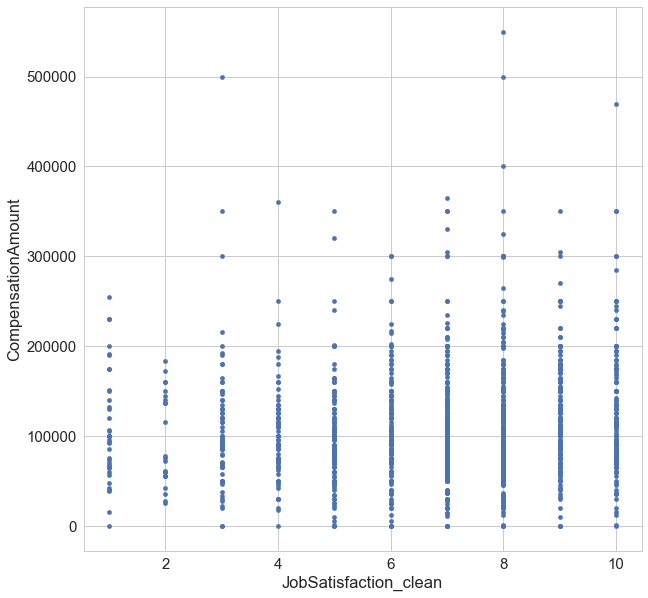

In [130]:
fig,ax= plt.subplots(1,1,figsize=(10,10))
df_mc_us_wdollars.plot.scatter(x ='JobSatisfaction_clean',y='CompensationAmount',ax=ax)

In [131]:
result = sm.ols(formula="CompensationAmount ~ JobSatisfaction_clean", data=df_mc_us_wdollars).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:     CompensationAmount   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     19.46
Date:                Wed, 21 Mar 2018   Prob (F-statistic):           1.10e-05
Time:                        12:44:27   Log-Likelihood:                -18972.
No. Observations:                1523   AIC:                         3.795e+04
Df Residuals:                    1521   BIC:                         3.796e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              9.214e+

### Conclusion: 

While the coeffiencets are statistically significant that is a very low R$^2$ term and would not be a great fit.

## Can we classify salaries using a decision tree?

In [133]:
work = ['TimeGatheringData',
'TimeModelBuilding',
'TimeProduction',
'TimeVisualizing',
'TimeFindingInsights',
'TimeOtherSelect']

temp  = df_mc_us_wdollars[work+['SalaryBracket']].copy()
temp = temp.dropna()

In [134]:
X = temp[work].as_matrix()
y = temp['SalaryBracket'].as_matrix()

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [136]:
clf = tree.DecisionTreeClassifier('gini',max_depth=4,min_samples_leaf=100)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=100, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

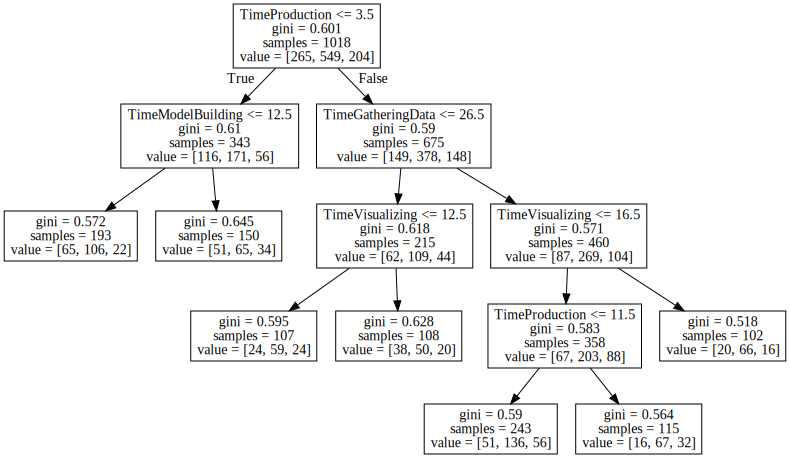

In [146]:
dot_data = tree.export_graphviz(clf, out_file=None,feature_names=work) 
graph = graphviz.Source(dot_data) 
graph

In [148]:
from graphviz import Source

In [149]:
# to save the image as a 
graph = Source( tree.export_graphviz(clf, out_file=None, feature_names=work))
graph.format = 'png'
graph.render('dtree_render',view=True)

'dtree_render.png'

In [68]:
clf.score(X_test, y_test)

0.536779324055666

In [69]:
for x,y in zip(clf.feature_importances_,work):
    print(y,x)

TimeGatheringData 0.13787250839443096
TimeModelBuilding 0.0
TimeProduction 0.41779375779585054
TimeVisualizing 0.34331468916740676
TimeFindingInsights 0.10101904464231179
TimeOtherSelect 0.0


### Conclusion: 

The accuracy value here is slightly better than 50% so there is something more than a guess occuring. More than future classification the feature imporatance and how the tree were formed was of interest to undesrtand the key variables which here were the time producing production level mdoels and time spent visualizing data.

### Do salary and ml techniques relate?

In [36]:
column = 'MLTechniquesSelect' 
method_coll = Counter()


for row in df_mc_us_wdollars[column].tolist():
    if type(row) != float:
        #print(row)
        method_coll.update(row.split(','))
        

In [40]:
method_coll

Counter({'Bayesian Techniques': 611,
         'Decision Trees - Gradient Boosted Machines': 745,
         'Decision Trees - Random Forests': 1052,
         'Ensemble Methods': 635,
         'Evolutionary Approaches': 136,
         'Gradient Boosting': 465,
         'Hidden Markov Models HMMs': 223,
         'Logistic Regression': 1257,
         'Markov Logic Networks': 92,
         'Neural Networks - CNNs': 434,
         'Neural Networks - GANs': 113,
         'Neural Networks - RNNs': 295,
         'Other (please specify; separate by semi-colon)': 97,
         'Support Vector Machines (SVMs)': 692})

In [120]:
skills = ['Bayesian Techniques',
       'Decision Trees - Gradient Boosted Machines',
       'Decision Trees - Random Forests', 'Ensemble Methods',
       'Evolutionary Approaches', 'Gradient Boosting',
       'Hidden Markov Models HMMs', 'Logistic Regression',
       'Markov Logic Networks', 'Neural Networks - CNNs',
       'Neural Networks - GANs', 'Neural Networks - RNNs',
       'Support Vector Machines (SVMs)',
       'Other (please specify; separate by semi-colon)']


temp  = df_mc_us_wdollars[['SalaryBracket','MLTechniquesSelect']].copy()

for skill in skills:
    temp[skill] = temp[column].apply(lambda x: ApplySkillMap(x,skill))
    
temp = temp.dropna()

In [122]:
X = temp[skills].as_matrix()
y = temp['SalaryBracket'].as_matrix()

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [55]:
clf = tree.DecisionTreeClassifier('gini',max_depth=4,min_samples_leaf=100)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=100, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

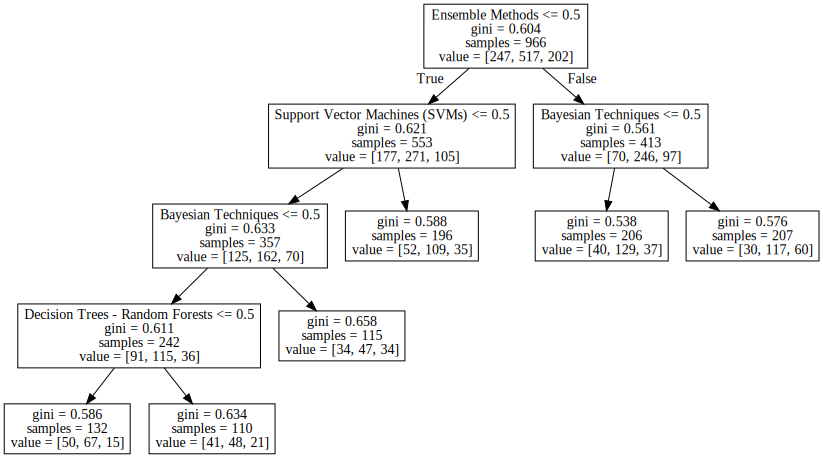

In [56]:
dot_data = tree.export_graphviz(clf, out_file=None,feature_names=skills) 
graph = graphviz.Source(dot_data) 
graph

In [57]:
clf.score(X_test, y_test)

0.5345911949685535

In [58]:
for x,y in zip(clf.feature_importances_,skills):
    print(y,x)

Bayesian Techniques 0.2791319609968703
Decision Trees - Gradient Boosted Machines 0.0
Decision Trees - Random Forests 0.041979688894234264
Ensemble Methods 0.5352389239275663
Evolutionary Approaches 0.0
Gradient Boosting 0.0
Hidden Markov Models HMMs 0.0
Logistic Regression 0.0
Markov Logic Networks 0.0
Neural Networks - CNNs 0.0
Neural Networks - GANs 0.0
Neural Networks - RNNs 0.0
Support Vector Machines (SVMs) 0.1436494261813291
Other (please specify; separate by semi-colon) 0.0


### Conclusion: 

Similar to above, the accuracy value here is slightly better than 50% so there is something more than a guess occuring. More than future classification the feature imporatance and how the tree were formed was of interest to undesrtand the key variables whicher were Ensembled methods and Bayesian techniques

### Does parameter tunning help us at all?

In [75]:
from sklearn.model_selection import GridSearchCV
from time import time

In [77]:
# set of parameters to test
param_grid = {"criterion": ["gini", "entropy"],
              "min_samples_split": [20, 40, 80, 100],
              "max_depth": [None, 2, 5],
              "min_samples_leaf": [20, 40, 80, 100],
              "max_leaf_nodes": [None, 5, 10, 20],
              }
#>>> clf = GridSearchCV(svc, parameters)
#>>> clf.fit(iris.data, iris.target)

In [78]:
dt = tree.DecisionTreeClassifier()
clf = GridSearchCV(dt, param_grid, cv=3)
clf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'min_samples_split': [20, 40, 80, 100], 'max_depth': [None, 2, 5], 'min_samples_leaf': [20, 40, 80, 100], 'max_leaf_nodes': [None, 5, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [79]:
sorted(clf.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'mean_train_score',
 'param_criterion',
 'param_max_depth',
 'param_max_leaf_nodes',
 'param_min_samples_leaf',
 'param_min_samples_split',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split0_train_score',
 'split1_test_score',
 'split1_train_score',
 'split2_test_score',
 'split2_train_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score',
 'std_train_score']

In [124]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=5, random_state=15,min_samples_leaf=50)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=15, verbose=0, warm_start=False)

In [125]:
clf.score(X_test, y_test)

0.5345911949685535

In [126]:
for x,y in zip(clf.feature_importances_,skills):
    print(y,x)

Bayesian Techniques 0.08119642975423946
Decision Trees - Gradient Boosted Machines 0.03772366343956296
Decision Trees - Random Forests 0.12937953077455905
Ensemble Methods 0.2053148450744359
Evolutionary Approaches 0.024435457588609582
Gradient Boosting 0.24859471123650514
Hidden Markov Models HMMs 0.03978951181826733
Logistic Regression 0.10677137807683452
Markov Logic Networks 0.0
Neural Networks - CNNs 0.005641293318869831
Neural Networks - GANs 0.0
Neural Networks - RNNs 0.017249869372521816
Support Vector Machines (SVMs) 0.10390330954559446
Other (please specify; separate by semi-colon) 0.0


### Conclusion: 

Parameter tunning did not gain us much. Admittedly the grid search could be have been wider.